## 1. Setup - Clone Repository

In [1]:
# Go to /content first, clean previous clone, then clone fresh
%cd /content
!rm -rf Deep_Learning_Project_Gil_Alon
!git clone https://github.com/gil-attar/Deep_Learning_Project_Gil_Alon.git
%cd Deep_Learning_Project_Gil_Alon

/content
Cloning into 'Deep_Learning_Project_Gil_Alon'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 65 (delta 29), reused 44 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 26.03 KiB | 26.03 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/Deep_Learning_Project_Gil_Alon


In [2]:
# Install dependencies
!pip install -r requirements.txt -q

## 2. Set API Keys

Replace with your actual keys below, or use Colab Secrets (🔑 icon in sidebar)

In [3]:
import os

# Option A: Set directly (replace with your keys)
os.environ["ROBOFLOW_API_KEY"] = "zEF9icmDY2oTcPkaDcQY"

# Option B: Use Colab Secrets (recommended)
# from google.colab import userdata
# os.environ["ROBOFLOW_API_KEY"] = userdata.get('ROBOFLOW_API_KEY')

## 3. Download Dataset

In [ ]:
!python scripts/download_dataset.py

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FOOD-INGREDIENTS-dataset-2-1 in yolov8:: 100%|██████████| 3980/3980 [00:01<00:00, 3007.80it/s]


Downloaded to: /content/Deep_Learning_Project_Gil_Alon/FOOD-INGREDIENTS-dataset-2-1
Moved train/
Moved valid/
Moved test/
Copied data.yaml

✓ Dataset ready in data/processed/


## 4. Build Evaluation Index

(Roboflow already split the data - no need to re-split!)

In [11]:
!python scripts/build_evaluation_index.py

BUILD EVALUATION INDEX

1. Finding dataset...
   Found: /content/Deep_Learning_Project_Gil_Alon/data/processed

2. Loading class names...
   Found 26 classes

3. Processing test images...
Found 400 test images

SUMMARY
  Total images: 400
  Total objects: 856
  Classes: 26

  Difficulty distribution:
    EASY    :  324 (81.0%)
    MEDIUM  :   53 (13.2%)
    HARD    :   23 (5.8%)

✅ Saved to: /content/Deep_Learning_Project_Gil_Alon/data/processed/test_index.json

Next steps:
  1. Train models (scripts/train_models.py)
  2. Run evaluation (scripts/evaluate_models.py)


## 6. Verify Results

In [12]:
# Check directory structure
!echo "=== Data Structure ==="
!ls -la data/processed/

!echo ""
!echo "=== Train/Valid/Test Counts ==="
!echo "Train images: $(ls data/processed/train/images/ | wc -l)"
!echo "Valid images: $(ls data/processed/valid/images/ | wc -l)"
!echo "Test images: $(ls data/processed/test/images/ | wc -l)"

=== Data Structure ===
total 540
drwxr-xr-x 5 root root   4096 Jan  8 13:42 .
drwxr-xr-x 4 root root   4096 Jan  8 13:38 ..
-rw-r--r-- 1 root root    544 Jan  8 13:42 data.yaml
-rw-r--r-- 1 root root      0 Jan  8 13:38 .gitkeep
drwxr-xr-x 4 root root   4096 Jan  8 13:42 test
-rw-r--r-- 1 root root 525299 Jan  8 13:42 test_index.json
drwxr-xr-x 4 root root   4096 Jan  8 13:42 train
drwxr-xr-x 4 root root   4096 Jan  8 13:42 valid

=== Train/Valid/Test Counts ===
Train images: 1384
Valid images: 200
Test images: 400


In [13]:
# Check the evaluation index
import json

with open('data/processed/test_index.json', 'r') as f:
    index = json.load(f)

print("=== Evaluation Index Summary ===")
print(f"Total test images: {index['metadata']['num_images']}")
print(f"Total objects: {index['metadata']['total_objects']}")
print(f"Classes: {index['metadata']['num_classes']}")
print(f"\nDifficulty distribution:")
for diff, count in index['metadata']['difficulty_distribution'].items():
    print(f"  {diff}: {count}")

=== Evaluation Index Summary ===
Total test images: 400
Total objects: 856
Classes: 26

Difficulty distribution:
  easy: 324
  medium: 53
  hard: 23


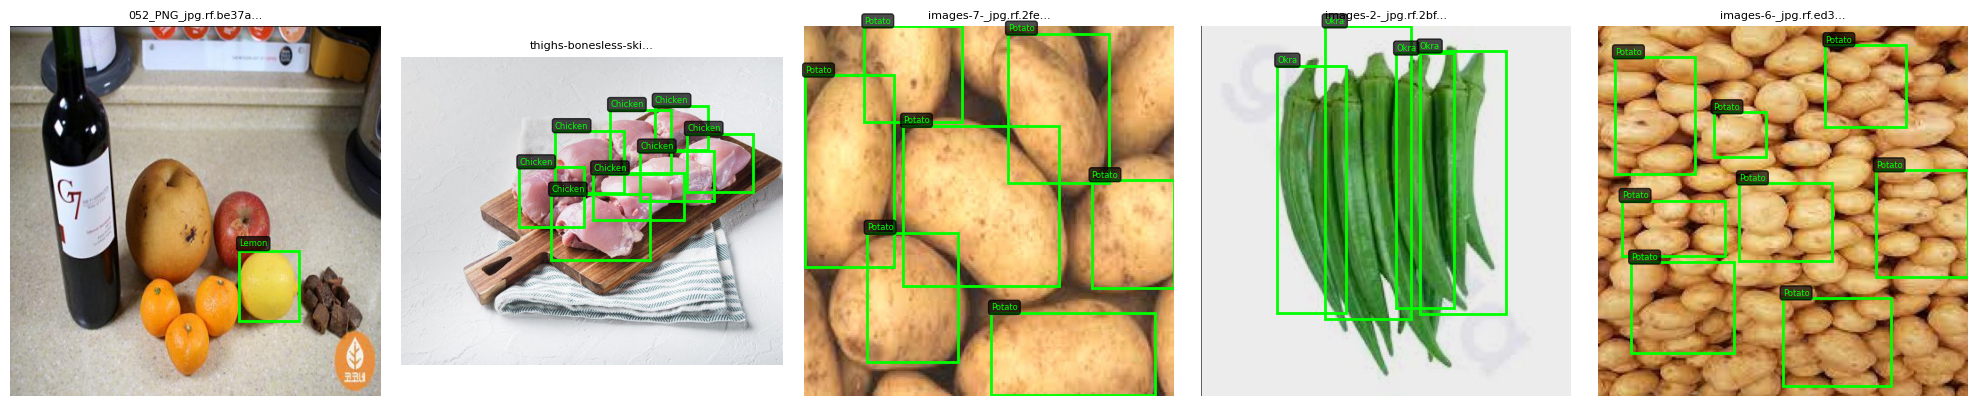

In [15]:
# Show 5 sample images with bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import yaml

# Load class names
with open('data/processed/data.yaml', 'r') as f:
    config = yaml.safe_load(f)
class_names = config['names']

# Get 5 sample images from test set
test_images_dir = Path('data/processed/test/images')
test_labels_dir = Path('data/processed/test/labels')
sample_images = list(test_images_dir.glob('*.jpg'))[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, img_path in zip(axes, sample_images):
    # Load image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_path.name[:20] + '...', fontsize=8)
    ax.axis('off')
    
    # Load labels and draw boxes
    label_path = test_labels_dir / (img_path.stem + '.txt')
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, w, h = [float(p) for p in parts[1:5]]
                    
                    # Convert YOLO format to pixel coordinates
                    img_w, img_h = img.size
                    x1 = (x_center - w/2) * img_w
                    y1 = (y_center - h/2) * img_h
                    box_w = w * img_w
                    box_h = h * img_h
                    
                    # Draw rectangle
                    rect = patches.Rectangle((x1, y1), box_w, box_h, 
                                            linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add label
                    label = class_names[class_id] if class_id < len(class_names) else f'class_{class_id}'
                    ax.text(x1, y1-5, label, fontsize=6, color='lime', 
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

## ✅ Data Pipeline Complete!

Next steps:
- Train models (Step 3)
- Evaluate and compare (Step 4)